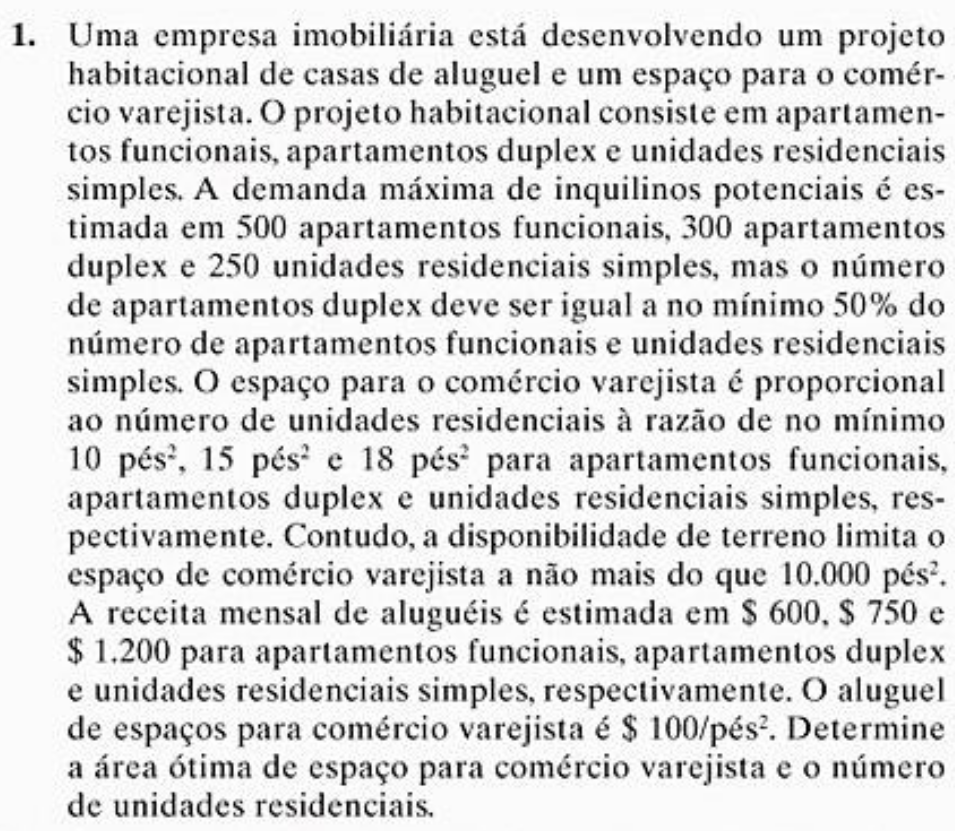

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Projeto_Imobiliario_Otimo')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Tipos de unidades residenciais
unidades_residenciais = ['funcional', 'duplex', 'simples']

# Dados de receita mensal
receita_aluguel_unidade = {'funcional': 600, 'duplex': 750, 'simples': 1200}
receita_aluguel_comercio_por_pe2 = 100

# Limites de demanda
demanda_maxima = {'funcional': 500, 'duplex': 300, 'simples': 250}

# Regras de construção e espaço
espaco_comercial_min_por_unidade = {'funcional': 10, 'duplex': 15, 'simples': 18} # em pés²
limite_max_espaco_comercial = 10000 # em pés²

In [4]:
# 1. Variáveis de Decisão
# Número de cada tipo de unidade residencial (inteiros)
num_unidades = model.integer_var_dict(unidades_residenciais, name='Num')

# Área do espaço comercial em pés² (contínuo)
area_comercial = model.continuous_var(name='AreaComercial')


# 2. Função Objetivo
# Maximizar a receita total (soma das receitas de aluguéis residenciais e comerciais)
expressao_receita_residencial = (receita_aluguel_unidade[u] * num_unidades[u] for u in unidades_residenciais)
soma_receita_residencial = model.sum(expressao_receita_residencial)
receita_comercial = receita_aluguel_comercio_por_pe2 * area_comercial
receita_total = soma_receita_residencial + receita_comercial
model.maximize(receita_total)


# 3. Restrições

# Restrição 1: Demanda Máxima por Tipo de Unidade
for u in unidades_residenciais:
    restr_demanda_logica = num_unidades[u] <= demanda_maxima[u]
    model.add_constraint(restr_demanda_logica, ctname=f'demanda_max_{u}')

# Restrição 2: Mix de Unidades
# Duplex >= 50% * (Funcionais + Simples) => D - 0.5*F - 0.5*S >= 0
restr_mix_logica = (num_unidades['duplex']
                    - 0.5 * num_unidades['funcional']
                    - 0.5 * num_unidades['simples'] >= 0)
model.add_constraint(restr_mix_logica, ctname='ratio_mix_unidades')

# Restrição 3: Proporcionalidade do Espaço Comercial
# A área comercial deve ser no mínimo a soma do espaço gerado por cada unidade residencial.
expressao_espaco_necessario = (espaco_comercial_min_por_unidade[u] * num_unidades[u] for u in unidades_residenciais)
soma_espaco_necessario = model.sum(expressao_espaco_necessario)
restr_proporcao_espaco_logica = area_comercial >= soma_espaco_necessario
model.add_constraint(restr_proporcao_espaco_logica, ctname='proporcao_espaco_comercial')

# Restrição 4: Limite Máximo de Terreno para Comércio
restr_max_espaco_logica = area_comercial <= limite_max_espaco_comercial
model.add_constraint(restr_max_espaco_logica, ctname='limite_max_espaco_comercial')

docplex.mp.LinearConstraint[limite_max_espaco_comercial](AreaComercial,LE,10000)

In [5]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
print(solucao)

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 4 rows and 1 columns.
MIP Presolve modified 1 coefficients.
Reduced MIP has 2 rows, 3 columns, and 6 nonzeros.
Reduced MIP has 0 binaries, 3 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 2 rows, 3 columns, and 6 nonzeros.
Reduced MIP has 0 binaries, 3 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.00 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 16 threads.
Root relaxation solution time = 0.00 sec. (0.00 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer   